# Long Term Stock Performance Predictions

## Business Understanding and Overview

For decades, many humans have attempted to predict the stock market. These attempts have varied in nature from predicting individual stock prices to predicting the direction of the overall market. While most argue that it's impossible to beat the market as an individual investor, I believe that with the right tools and technology, individuals can indeed outperform the market. While I believe this idea is possible, the data shows that individual investors' performances are dreadful on average when compared to the broader market. The bar chart below shows that the average investor had annual returns of 1.9% from 1999-2018 while the S&P500 returned 5.6%.

 ![](images/IndInvInfographic.jpeg)

Currently, to be a well-versed individual investor requires significant time researching companies, listening to earnings calls, and having an understanding of macro-economic trends. Most people do not have the time to become knowledgable on multiple companies that are publicly traded, so it's easier and safer to invest in index funds that track the overall market. But what if there was a tool that could quickly let individual investors know which companies can beat the market over an extended period of time?


## Data Understanding

I have sourced all the required data myself using the SEC's API. I used this API to pull the annual reports (10-K) for public companies from 2009-2012. I could not get any useful data from before 2009 because the SEC didn't require companies to file in XBRL format until then. In the future, I plan to use other methods to acquire and clean data prior to 2009 in the future. I stopped collecting data past 2012 because I need a 10 year window to determine if a stock outperformed the market over 10 years based on their financials. The link to the SEC API can be [found here](https://sec-api.io/). I will write a blog post explaining how to use this API in the future and link that here. Stay tuned!

In terms of metrics that I will use to score the performance of my model, recall will be the most important metric followed by precision. Recall will score how my model does at identifying stocks that do outperform the market. Investors will care more about finding the stocks that can outperform the market rather than correctly identifying those that underperform. Precision will also be a key metric because this gives a score for how accurate our model performs when predicting that a stock does outperform the market. To simplify the metrics I use, I can also use the f1 score as this is the harmonic mean of precision and recall. For my grid searches, it will make more sense to use f1 scoring because the grid search evaluates on one metric rather than two. 


## Modeling Preparation

In [1]:
# Import all relevant packages for modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as SNS
%matplotlib inline

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, \
                            plot_confusion_matrix, plot_roc_curve, roc_auc_score, classification_report, \
                            ConfusionMatrixDisplay, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

import xgboost
from xgboost import XGBClassifier


/Users/zachpollatsek/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/zachpollatsek/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Create our sub pipelines for numeric and categorial data
# also include pipeline for SMOTE to fix our class imbalance issue
subpipe_num = Pipeline(steps=[('ss', StandardScaler()),
                              ('pca', PCA(n_components=0.95))])
subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False,
                                                    handle_unknown='ignore'))])
subpipe_smote = SMOTE(sampling_strategy='minority', random_state=42)

In [3]:
# Include our sub pipelines in a column transformer to OHE our categorial variables and scale our numerical variables.
CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, [0,1,2,3,4,5,6,7]), 
                                     ('subpipe_cat', subpipe_cat, [8])])

In [4]:
# read in the data to a dataframe
df = pd.read_csv('./data/modeling_df2')

In [5]:
# get an idea of how the companies in our sample breakdown by sector
df['sector'].value_counts()

Technology                51
Industrials               44
Healthcare                32
Consumer Cyclical         24
Basic Materials           10
Energy                    10
Consumer Defensive        10
Financial Services        10
Communication Services     7
Utilities                  5
Real Estate                4
Name: sector, dtype: int64

In [6]:
df.head()

,Unnamed: 0,year,CIK,AssetsCurrent,LiabilitiesCurrent,NetCashProvidedByUsedInOperatingActivities,NetCashProvidedByUsedInInvestingActivities,NetCashProvidedByUsedInFinancingActivities,CashAndCashEquivalentsPeriodIncreaseDecrease,OperatingIncomeLoss,NetIncomeLoss,ticker,10yrReturns,SPY,marketBeat?,sector
0,0,2009,1140859,9953753000,9479610000,783763000,-1.483490e+08,-504160000,131254000,883749000,503397000,ABC,382.872,230.065,1,Healthcare
1,1,2009,829224,2035800000,1581000000,1389000000,-4.211000e+08,-642200000,330000000,562000000,390800000,SBUX,1404.256,230.065,1,Consumer Cyclical
2,2,2009,796343,2473624000,844553000,1117772000,-1.497096e+09,477658000,113037000,690513000,386508000,ADBE,875.543,230.065,1,Technology
3,3,2009,875045,2480595000,714942000,1074898000,-3.950310e+08,-724151000,-44284000,1295427000,970132000,BIIB,528.356,230.065,1,Healthcare
4,4,2009,100885,3680000000,2682000000,3234000000,-2.175000e+09,-458000000,601000000,3392000000,1898000000,UNP,578.284,230.065,1,Industrials


In [7]:
# perform initial inspection to see how the returns of companies compare
df.groupby('marketBeat?').median()

,Unnamed: 0,year,CIK,AssetsCurrent,LiabilitiesCurrent,NetCashProvidedByUsedInOperatingActivities,NetCashProvidedByUsedInInvestingActivities,NetCashProvidedByUsedInFinancingActivities,CashAndCashEquivalentsPeriodIncreaseDecrease,OperatingIncomeLoss,NetIncomeLoss,10yrReturns,SPY
marketBeat?,,,,,,,,,,,,,
0,110.0,2011.0,931148.0,74470000.0,37034000.0,7749000.0,-5554966.0,21925.0,-848.5,4779808.5,1678000.0,-18.467,254.2
1,94.0,2011.0,974928.5,491271000.0,187483000.0,120272500.0,-52150000.0,-8535000.0,2676494.5,78277000.0,34928000.0,552.103,254.2


As we can see from the above groupby, the median 10 year return for a company that underperforms the market is -18.47% while the median 10 year return for a company that outperforms the market is 552.10%. This clear difference is important because even with a low accuracy, this model can help ensure that the stocks you buy have a better chance of winning. 

In [8]:
# check the breakdown of our target column
df['marketBeat?'].value_counts(normalize=True)

0    0.721154
1    0.278846
Name: marketBeat?, dtype: float64

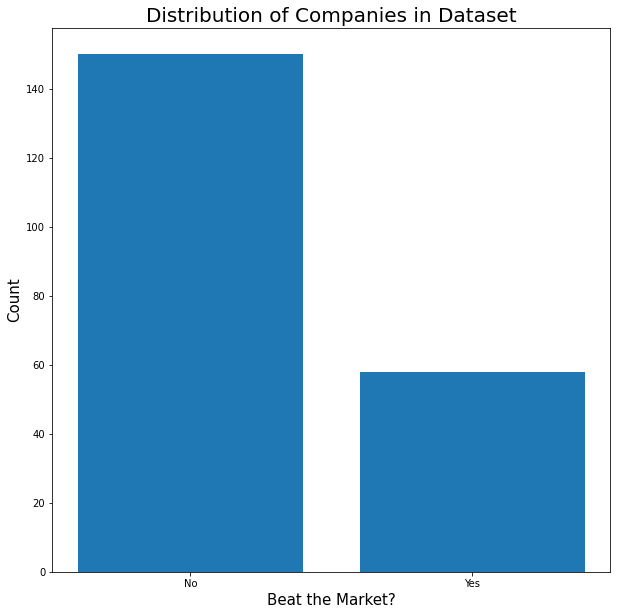

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.bar([0,1], df['marketBeat?'].value_counts());
ax.set_xlabel('Beat the Market?', fontsize=15);
ax.set_ylabel('Count', fontsize=15);
ax.set_title('Distribution of Companies in Dataset', fontsize=20);
ax.set_xticks([0,1]);
ax.set_xticklabels(['No', 'Yes']);
#ax.text(-.35, 80, '10yr Returns: -18.47%', fontsize=18, color='white');
#ax.text(0.63, 30, '10yr Returns: 552.10%', fontsize=18, color='white');

plt.savefig('./images/DistCompany.png', dpi=400, facecolor='white')

## Data Preparation

In [10]:
# split our dataframe into our features and target dataframes
X = df.drop(columns=['Unnamed: 0', 'year', 'CIK', 'ticker', '10yrReturns', 'SPY', 'marketBeat?'])
y = df['marketBeat?']

In [11]:
# perform test_train_split to get our train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [12]:
# further split our data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [13]:
# fit our column transformer to X_train
CT.fit(X_train)

ColumnTransformer(transformers=[('subpipe_num',
                                 Pipeline(steps=[('ss', StandardScaler()),
                                                 ('pca',
                                                  PCA(n_components=0.95))]),
                                 [0, 1, 2, 3, 4, 5, 6, 7]),
                                ('subpipe_cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 [8])])

In [14]:
# transform all our feature dataframes according to our column transformer. 
# For any model with the column transformer in a pipeline, I can simply use X_train rather than X_tr_final
X_tr_final = CT.transform(X_train)
X_val_final = CT.transform(X_val)
X_te_final = CT.transform(X_test)

In [15]:
pd.DataFrame(X_tr_final).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.563256,0.119657,-0.076771,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.619560,0.044051,0.105057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.502677,0.169339,0.140278,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.210238,0.119686,-0.297015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.523659,0.242559,-0.020217,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
y_test.values

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1])

## Modeling

### Dummy Model

In [49]:
# instantiate our dummy model with the strategy to predict the most frequent class
dummy = DummyClassifier(strategy='most_frequent')

In [50]:
# fit the dummy model onto our training data
dummy.fit(X_tr_final, y_train)

DummyClassifier(strategy='most_frequent')

In [51]:
# determine the accurary score of our dummy model on validation data
dummy.score(X_val_final, y_val)

0.6666666666666666

In [52]:
# view confusion matrix
confusion_matrix(y_val, dummy.predict(X_val_final))

array([[26,  0],
       [13,  0]])

In [53]:
dummy_f1 = f1_score(y_val, dummy.predict(X_val_final))
dummy_f1

0.0

### Simple Models

#### Logistic Regresssion

In [54]:
# instantiate a logistic regression model with default hyperparameters
lr = LogisticRegression(random_state=42)

In [55]:
# fit the logistic regression model to our training data
lr.fit(X_tr_final, y_train)

LogisticRegression(random_state=42)

In [56]:
# calculate the accuracy of the logistic regression model on the validation data
lr.score(X_val_final, y_val)

0.6666666666666666

In [57]:
# view confusion matrix
confusion_matrix(y_val, lr.predict(X_val_final))

array([[26,  0],
       [13,  0]])

In [58]:
lr_f1 = f1_score(y_val, lr.predict(X_val_final))
lr_f1

0.0

#### Decision Tree Classifier

In [59]:
# instantiate a decision tree classifier model with default hyperparameters
dt = DecisionTreeClassifier(random_state=42)

In [60]:
# fit the decision tree classifier to our training data
dt.fit(X_tr_final, y_train)

DecisionTreeClassifier(random_state=42)

In [61]:
# calculate the accuracy of the decision tree model on the validation data
dt.score(X_val_final, y_val)

0.6666666666666666

In [62]:
# view the confusion matrix
confusion_matrix(y_val, dt.predict(X_val_final))

array([[23,  3],
       [10,  3]])

In [63]:
dt_f1 = f1_score(y_val, dt.predict(X_val_final))
dt_f1

0.3157894736842105

#### KNN Classifier

In [31]:
# instantiate a k nearest neighbors classifier with default hyper parameters
knn = KNeighborsClassifier()

In [32]:
# fit k nearest neighbors model to our training data
knn.fit(X_tr_final, y_train)

KNeighborsClassifier()

In [33]:
# calculate the accuracy of the knn model on the validation data
knn.score(X_val_final, y_val)

0.717948717948718

In [34]:
# view the confusion matrix
confusion_matrix(y_val, knn.predict(X_val_final))

array([[25,  1],
       [10,  3]])

In [35]:
knn_f1 = f1_score(y_val, knn.predict(X_val_final))
knn_f1

0.3529411764705882

#### Random Forest Classifier

In [36]:
# instantiate a random forest classifier with default hyperparameters
rfc = RandomForestClassifier(random_state=42)

In [37]:
# fit random forest model to training data
rfc.fit(X_tr_final, y_train)

RandomForestClassifier(random_state=42)

In [38]:
# calculate the accuracy of the model on validation data
rfc.score(X_val_final, y_val)

0.6923076923076923

In [39]:
# view the confusion matrix
confusion_matrix(y_val, rfc.predict(X_val_final))

array([[25,  1],
       [11,  2]])

In [40]:
rfc_f1 = f1_score(y_val, rfc.predict(X_val_final))
rfc_f1

0.25

#### XGBoost Classifier

In [41]:
# instantiate an XGBoost classifier with default hyperparameters
xgb = XGBClassifier(random_state=42)

In [42]:
# fit XGBoost model to the training data
xgb.fit(X_tr_final, y_train)

[14:17:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zachpollatsek/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
# calculate the accuracy of this model on the validation data
xgb.score(X_val_final, y_val)

0.6923076923076923

In [44]:
# view the confusion matrix
confusion_matrix(y_val, xgb.predict(X_val_final))

array([[24,  2],
       [10,  3]])

In [45]:
xgb_f1 = f1_score(y_val, xgb.predict(X_val_final))
xgb_f1

0.33333333333333337

## Random Forest Grid Search

In [46]:
# create pipeline for random forest model 
rfc_pipe = Pipeline(steps=[('CT', CT),
                           ('rfc', RandomForestClassifier(random_state=42))])

In [47]:
# create our grid for the grid search parameters
params = {'rfc__n_estimators': [50, 100, 150],
          'rfc__min_samples_split': [2, 10, 50],
          'rfc__max_depth': [3, 6, 12]}

In [48]:
# instantiate grid search object
grid_rfc = GridSearchCV(rfc_pipe, param_grid=params, cv=5, verbose=3)

In [49]:
# fit grid search object to training data
#grid_rfc.fit(X_train, y_train)

In [50]:
#grid_rfc.best_params_

In [51]:
# create a random forest model with the hyperparameters from our grid search
best_rfc = RandomForestClassifier(max_depth=6, min_samples_split=10, n_estimators=50)

In [52]:
best_rfc.fit(X_tr_final, y_train)

RandomForestClassifier(max_depth=6, min_samples_split=10, n_estimators=50)

In [53]:
best_rfc.score(X_val_final, y_val)

0.6666666666666666

In [54]:
confusion_matrix(y_val, best_rfc.predict(X_val_final))

array([[25,  1],
       [12,  1]])

## XGBoost Grid Search

In [55]:
# create XGBoost pipeline for grid search
xgb_pipe = Pipeline(steps=[('CT', CT),
                           ('XGB', XGBClassifier(random_state=42))])

In [56]:
# create our massive grid for the grid search parameters
params2 = {
    'XGB__learning_rate': [0.1, 0.2],
    'XGB__max_depth': range(3, 10, 2),
    'XGB__min_child_weight': range(1, 8, 2),
    'XGB__gamma': [0, .1, .2],
    'XGB__subsample': [.5, .75, 1]
}

In [57]:
# instantiate grid search object for XGBoost
grid_xgb = GridSearchCV(xgb_pipe, param_grid=params2, cv=5, verbose=3)

In [58]:
# fit grid search object to training data
#grid_xgb.fit(X_train, y_train)

In [59]:
#grid_xgb.best_params_

In [60]:
# calculate the best accuracy score for XGBoost grid search
#grid_xgb.best_score_

In [61]:
# instantiate an XGBoost model with hyperparameters from grid search
best_xgb = XGBClassifier(gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=5, subsample=1, random_state=42)

In [62]:
best_xgb.fit(X_tr_final, y_train)

[14:17:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zachpollatsek/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=3, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [63]:
best_xgb.score(X_val_final, y_val)

0.6666666666666666

In [64]:
confusion_matrix(y_val, best_xgb.predict(X_val_final))

array([[25,  1],
       [12,  1]])

## Stacking Classifier

In [65]:
# Instantiate initial stacking classifier object with our two models
stack = StackingClassifier(estimators=[('RandForest', rfc_pipe),
                                       ('XGBoost', xgb_pipe)],
                           verbose=3)

In [66]:
# fit stacking classifier to the training data
stack.fit(X_train, y_train)

/Users/zachpollatsek/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[14:17:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/zachpollatsek/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/Users/zachpollatsek/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The 

[14:17:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
/Users/zachpollatsek/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/zachpollatsek/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  

[14:17:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zachpollatsek/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


[14:17:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


StackingClassifier(estimators=[('RandForest',
                                Pipeline(steps=[('CT',
                                                 ColumnTransformer(transformers=[('subpipe_num',
                                                                                  Pipeline(steps=[('ss',
                                                                                                   StandardScaler()),
                                                                                                  ('pca',
                                                                                                   PCA(n_components=0.95))]),
                                                                                  [0,
                                                                                   1,
                                                                                   2,
                                                                                   3,
                                                                                   4,
                                                                                   5,
                                                                                   6,
                                                                                   7]),
                                                                                 ('subpipe_cat',
                                                                                  Pipeline(steps=[('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse=False))]),
                                                                                  [8])])),
                                                ('rfc',
                                                 RandomForestClassifier(random_state=...
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=42,
                                                               reg_alpha=None,
                                                               reg_lambda=None,
                                                               scale_pos_weight=None,
                                                               subsample=None,
                                                               tree_method=None,
                                                               validate_parameters=None,
                                                               verbosity=None))]))],
                   verbose=3)

In [67]:
# calculate accuracy of stacking classifier for validation data
stack.score(X_val, y_val)

0.6666666666666666

In [68]:
confusion_matrix(y_val, stack.predict(X_val))

array([[26,  0],
       [13,  0]])

In [69]:
# set up grid search for stacking classifier
stack_params = {
    'RandForest__rfc__n_estimators': [50, 100, 150],
    'RandForest__rfc__max_depth': [2, 5, 10, 15],
    'RandForest__rfc__max_features': [0.1, 0.2, 0.5, 1], 
    'XGBoost__XGB__max_depth': [2, 5, 10, 20],
    'XGBoost__XGB__booster': ['gbtree', 'gblinear'],
    'XGBoost__XGB__eta': [0.1, 0.3, 0.5]
}

In [70]:
stack_grid = GridSearchCV(stack, param_grid=stack_params, cv=5, verbose=3)

In [71]:
#stack_grid.fit(X_train, y_train)

In [72]:
#stack_grid.best_params_

In [73]:
#stack_grid.best_score_

In [74]:
#stacking_results = pd.DataFrame(stack_grid.cv_results_)

In [75]:
#stacking_results.head()

In [76]:
#stacking_results.to_csv('./model_results/stacking_initial')

In [77]:
rfc_grid_v2 = Pipeline(steps=[('CT', CT),
                              ('rfc', RandomForestClassifier(random_state=42))])

In [78]:
params3 = {
    'rfc__n_estimators': [10, 25, 62, 150],
    'rfc__max_depth': [2, 3, 5, 8],
    'rfc__max_features': [0.1, 0.2, 0.5], 
    'rfc__criterion': ['gini', 'entropy'],
    'rfc__min_impurity_decrease': [0.05, 0.1, 0.25, 0.5]
    
}

In [79]:
rfc_grid_model = GridSearchCV(rfc_grid_v2, param_grid=params3, cv=5, verbose=3)

In [80]:
#rfc_grid_model.fit(X_train, y_train)

In [81]:
#pd.DataFrame(rfc_grid_model.cv)

In [82]:
#rfc_grid_model.best_params_

In [83]:
#rfc_grid_model.best_score_

In [84]:
rfc_best = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=2, max_features=0.1, min_impurity_decrease=0.05, random_state=42)

In [85]:
rfc_best.fit(X_tr_final, y_train)

RandomForestClassifier(max_depth=2, max_features=0.1,
                       min_impurity_decrease=0.05, n_estimators=10,
                       random_state=42)

In [88]:
cv_best_rfc = cross_val_score(rfc_best, X_tr_final, y_train, cv=5, scoring='f1')

In [89]:
cv_best_rfc

array([0., 0., 0., 0., 0.])

In [90]:
rfc_best.score(X_val_final, y_val)

0.6666666666666666

In [91]:
confusion_matrix(y_val, rfc_best.predict(X_val_final))

array([[26,  0],
       [13,  0]])

## SMOTE Models

Given our class inbalance problem, we will try to use SMOTE to improve our results. 

In [92]:
# create an Imblearn pipeline for random forest model with synthetic oversampling of the minority class
rfc_smote = ImPipeline(steps=[('CT', CT),
                              ('SM', subpipe_smote),
                              ('rfc', RandomForestClassifier(n_estimators=10, criterion='gini', 
                                                             max_depth=2, 
                                                             max_features=0.1, 
                                                             min_impurity_decrease=0.05, 
                                                             random_state=42))])

In [93]:
# fit RFC pipeline to the training data
rfc_smote.fit(X_train, y_train)

Pipeline(steps=[('CT',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [8])])),
                ('SM', SMOTE(random_state=42, sampling_strategy='minority')),
                ('rfc',
                 RandomForestClassifier(max_depth=2, max_features=0.1,
                                        min_impurity_decrease=0.05,
                                        n_estimators=10, random_state=42))])

In [94]:
# calculate the accuracy of this model with the validation data
rfc_smote.score(X_val, y_val)

0.6410256410256411

In [95]:
# view the confusion matrix
confusion_matrix(y_val, rfc_smote.predict(X_val))

array([[18,  8],
       [ 6,  7]])

In [96]:
rfc_smote.score(X_train, y_train)

0.5470085470085471

In [45]:
rfc_smote.score(X_val, y_val)

0.6410256410256411

In [98]:
rfc_smote_f1 = f1_score(y_val, rfc_smote.predict(X_val))
rfc_smote_f1

0.5

Given that our accuracy score for the validation data is significantly less than that of the training data, our model is slightly underfit and we can add more complexity. We will try using the XGBoost classifier again with the addition of SMOTE. If that model appears to perform better with SMOTE, I will create a stacking classifier of random forest and XGBoost.

In [99]:
# create an Imblearn pipeline for random forest model with synthetic oversampling of the minority class
xgb_smote = ImPipeline(steps=[('CT', CT),
                              ('SM', subpipe_smote),
                              ('xgb', XGBClassifier(gamma=0, 
                                                    learning_rate=0.2, 
                                                    max_depth=3, 
                                                    min_child_weight=5, 
                                                    subsample=1, 
                                                    random_state=42))])

In [100]:
xgb_smote.fit(X_train, y_train)

[14:19:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zachpollatsek/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('CT',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [8])])),
                ('SM', SMOTE(random_state=42, sampling_strategy='minority')),
                ('xgb',
                 XGBClassifier(base_sco...
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=5, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [101]:
xgb_smote.score(X_val, y_val)

0.717948717948718

In [102]:
confusion_matrix(y_val, xgb_smote.predict(X_val))

array([[23,  3],
       [ 8,  5]])

The precision of this model is 62.5%, which is the best we have seen thus far. Now I will create a stacking classifier with both models and the SMOTEd data. 

In [103]:
smote_stack = StackingClassifier(estimators=[('RFC', rfc_smote),
                                             ('XGBoost', xgb_smote)],
                                 verbose=3)

In [104]:
smote_stack.fit(X_train, y_train)

/Users/zachpollatsek/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[14:19:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zachpollatsek/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/Users/zachpollatsek/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  

[14:19:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:19:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:19:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

/Users/zachpollatsek/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/zachpollatsek/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:19:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


StackingClassifier(estimators=[('RFC',
                                Pipeline(steps=[('CT',
                                                 ColumnTransformer(transformers=[('subpipe_num',
                                                                                  Pipeline(steps=[('ss',
                                                                                                   StandardScaler()),
                                                                                                  ('pca',
                                                                                                   PCA(n_components=0.95))]),
                                                                                  [0,
                                                                                   1,
                                                                                   2,
                                                                                   3,
                                                                                   4,
                                                                                   5,
                                                                                   6,
                                                                                   7]),
                                                                                 ('subpipe_cat',
                                                                                  Pipeline(steps=[('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse=False))]),
                                                                                  [8])])),
                                                ('SM',
                                                 SMOTE(random_state=42,
                                                       sampling_strategy='min...
                                                               importance_type=None,
                                                               interaction_constraints='',
                                                               learning_rate=0.2,
                                                               max_delta_step=0,
                                                               max_depth=3,
                                                               min_child_weight=5,
                                                               missing=nan,
                                                               monotone_constraints='()',
                                                               n_estimators=100,
                                                               n_jobs=8,
                                                               num_parallel_tree=1,
                                                               predictor='auto',
                                                               random_state=42,
                                                               reg_alpha=0,
                                                               reg_lambda=1,
                                                               scale_pos_weight=1,
                                                               subsample=1,
                                                               tree_method='exact',
                                                               validate_parameters=1,
                                                               verbosity=None))]))],
                   verbose=3)

In [105]:
smote_stack.score(X_val, y_val)

0.6666666666666666

In [106]:
confusion_matrix(y_val, smote_stack.predict(X_val))

array([[26,  0],
       [13,  0]])

In [107]:
smote_stack.score(X_train, y_train)

0.7435897435897436

The combination of both classification models performs worse on our validation data, so I will perform grid searchs with SMOTE and each complex model (random forest and xgboost) to determine which type of model performs best. 

## Grid Searches with SMOTE

In [108]:
# create an Imblearn pipeline for random forest model with synthetic oversampling of the minority class
rfc_smote = ImPipeline(steps=[('CT', CT),
                              ('SM', subpipe_smote),
                              ('rfc', RandomForestClassifier(random_state=42))])

In [109]:
params_smote_rfc = {
    'rfc__n_estimators': [10, 25, 62, 150],
    'rfc__max_depth': [2, 3, 5, 8],
    'rfc__max_features': [0.1, 0.2, 0.5], 
    'rfc__criterion': ['gini', 'entropy'],
    'rfc__min_impurity_decrease': [0.05, 0.1, 0.25, 0.5]
    
}

In [110]:
rfc_smote_grid = GridSearchCV(rfc_smote, param_grid=params_smote_rfc, cv=5, verbose=3, scoring='f1')

In [111]:
#rfc_smote_grid.fit(X_train, y_train)

In [112]:
#rfc_smote_grid.best_score_

In [113]:
#rfc_smote_grid.best_params_

In [114]:
#rfc_smote_data = pd.DataFrame(rfc_smote_grid.cv_results_)

In [115]:
#rfc_smote_data.to_csv('./model_results/rfc_smote_grid')

Now, I will repeat the grid search process from above but for XGBoost. Afterwards, I will compare the F1 scores and confusion matrices.

In [38]:
# instantiate Imblearn pipeline for XGBoost with SMOTEd data to run a grid search on
xgb_smote_grid = ImPipeline(steps=[('CT', CT),
                                   ('SM', subpipe_smote),
                                   ('XGB', XGBClassifier(random_state=42))])

In [39]:
params_smote_xgb = {
    'XGB__learning_rate': [0.05, 0.1, 0.2],
    'XGB__max_depth': range(2, 8),
    'XGB__min_child_weight': range(1, 5),
    'XGB__gamma': [0, .1, .2],
    'XGB__subsample': [.5, .75, 1]
}

In [40]:
xgb_smote_grid = GridSearchCV(xgb_smote_grid, param_grid=params_smote_xgb, cv=5, verbose=3, scoring='f1')

In [116]:
#xgb_smote_grid.fit(X_train, y_train)

In [117]:
#xgb_smote_grid.best_score_

In [118]:
#xgb_smote_grid.best_params_

In [119]:
#xgb_smote_data = pd.DataFrame(xgb_smote_grid.cv_results_)

In [120]:
#xgb_smote_data.to_csv('./model_results/xgb_smote_grid')

## Check models with hyperparameters found from grid searches

In [20]:
rfc_best = ImPipeline(steps=[('CT', CT),
                             ('SM', subpipe_smote),
                             ('rfc', RandomForestClassifier(criterion='entropy',
                                                            max_depth=2,
                                                            max_features=0.1,
                                                            min_impurity_decrease=0.1,
                                                            n_estimators=150,
                                                            random_state=42))])

In [17]:
xgb_best =  ImPipeline(steps=[('CT', CT),
                              ('SM', subpipe_smote),
                              ('XGB', XGBClassifier(gamma=0,
                                                    learning_rate=0.05,
                                                    max_depth=2, 
                                                    min_child_weight=3,
                                                    subsample=0.5,
                                                    random_state=42))])

In [21]:
rfc_best.fit(X_train, y_train)

Pipeline(steps=[('CT',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [8])])),
                ('SM', SMOTE(random_state=42, sampling_strategy='minority')),
                ('rfc',
                 RandomForestClassifier(criterion='entropy', max_depth=2,
                                        max_features=0.1,
                                        min_impurity_decrease=0.1,
                                        n_estimators=150, random_state=42))])

In [18]:
xgb_best.fit(X_train, y_train)

[09:33:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zachpollatsek/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('CT',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [8])])),
                ('SM', SMOTE(random_state=42, sampling_strategy='minority')),
                ('XGB',
                 XGBClassifier(base_sco...
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.05,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=3, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=0.5,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [22]:
rfc_best.score(X_val, y_val)

0.6666666666666666

In [23]:
rfc_best.score(X_train, y_train)

0.5811965811965812

In [24]:
xgb_best.score(X_val, y_val)

0.6923076923076923

In [25]:
xgb_best.score(X_train, y_train)

0.7264957264957265

In [26]:
confusion_matrix(y_val, rfc_best.predict(X_val))

array([[19,  7],
       [ 6,  7]])

In [27]:
confusion_matrix(y_val, xgb_best.predict(X_val))

array([[19,  7],
       [ 5,  8]])

In [28]:
final_rfc_f1 = f1_score(y_val, rfc_best.predict(X_val))
final_rfc_f1

0.5185185185185186

In [29]:
final_xgb_f1 = f1_score(y_val, xgb_best.predict(X_val))
final_xgb_f1

0.5714285714285715

Both models gave very similar results, but the XGBoost classifier was marginally better in terms of the f1 score, so I will select this as my final model. 

In [30]:
xgb_best.score(X_test, y_test)

0.6538461538461539

In [31]:
final_f1 = f1_score(y_test, xgb_best.predict(X_test))
final_f1

0.4000000000000001

In [32]:
confusion_matrix(y_test, xgb_best.predict(X_test))

array([[28,  9],
       [ 9,  6]])

/Users/zachpollatsek/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


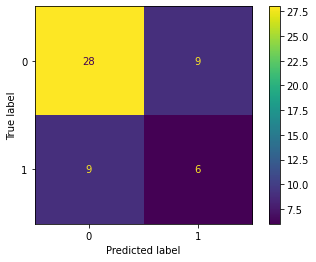

In [33]:
plot_confusion_matrix(xgb_best, X_test, y_test);
plt.savefig('./images/finalconfusion.png', dpi=400, facecolor='white')

The recall and precision for our final model on the unseen data are both 40%, which seems low, but in the context of this predictor, this is very solid. This score is solid because the median 10 year return for a stock that beats the market is 552.10% while that of a stock that underperforms the market is -18.47%. For example, if one were to invest \\$1,000 into each stock that was predicted to outperform the market based on the confusion matrix for our final model, they would invest \\$6,000 into stocks that do beat the market, and \\$9,000 into stocks that don't beat the market.

Following the median returns for this simple example, the \\$6,000 would grow to \\$39,000 over 10 years and the \\$9,000 would shrink to \\$7,340. This means that your net gain would be \\$31,340 or 208.9%. This corresponds to a 12% compound annual growth rate, which beats what many long term investors consider to be a good CAGR for 10 year returns: 10%. Next, I will look into the actual returns of the 15 stocks selected in my portfolio.

In [34]:
y_updated_test = X_test

In [35]:
y_updated_test['marketBeat?'] = y_test

In [36]:
# create the predicted labels for our test set
y_preds = xgb_best.predict(X_test)
y_preds

array([0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0])

In [37]:
# add the predicted label to our new dataframe
y_updated_test['prediction'] = y_preds

In [38]:
# only select companies that the model predicts will beat the market
y_updated_test_beat = y_updated_test[y_updated_test['prediction'] == 1]

In [39]:
y_updated_test_beat.head()

,AssetsCurrent,LiabilitiesCurrent,NetCashProvidedByUsedInOperatingActivities,NetCashProvidedByUsedInInvestingActivities,NetCashProvidedByUsedInFinancingActivities,CashAndCashEquivalentsPeriodIncreaseDecrease,OperatingIncomeLoss,NetIncomeLoss,sector,marketBeat?,prediction
15,9904000000,8386000000,2453000000,-761000000.0,-1266000000,426000000,788000000,376000000,Industrials,1,1
9,1997600000,624600000,218500000,-453700000.0,474100000,238900000,92700000,31700000,Industrials,0,1
18,1226100000,445000000,266200000,-54700000.0,45500000,262200000,367800000,217200000,Industrials,1,1
84,83603000,83972000,64494000,-10614000.0,-41595000,12207000,54947000,34100000,Industrials,0,1
170,789274000,476513000,266490000,-281539000.0,302584000,275607000,149360000,125174000,Technology,0,1


In [40]:
# add the 10 year returns back into the dataframe
test_portfolio = pd.merge(y_updated_test_beat, df['10yrReturns'], left_index=True, right_index=True)

In [41]:
test_portfolio.head()

,AssetsCurrent,LiabilitiesCurrent,NetCashProvidedByUsedInOperatingActivities,NetCashProvidedByUsedInInvestingActivities,NetCashProvidedByUsedInFinancingActivities,CashAndCashEquivalentsPeriodIncreaseDecrease,OperatingIncomeLoss,NetIncomeLoss,sector,marketBeat?,prediction,10yrReturns
15,9904000000,8386000000,2453000000,-761000000.0,-1266000000,426000000,788000000,376000000,Industrials,1,1,770.519
9,1997600000,624600000,218500000,-453700000.0,474100000,238900000,92700000,31700000,Industrials,0,1,-2.913
18,1226100000,445000000,266200000,-54700000.0,45500000,262200000,367800000,217200000,Industrials,1,1,293.347
84,83603000,83972000,64494000,-10614000.0,-41595000,12207000,54947000,34100000,Industrials,0,1,-84.663
170,789274000,476513000,266490000,-281539000.0,302584000,275607000,149360000,125174000,Technology,0,1,316.699


In [42]:
# create a new column for the final value of a $1,000 investment into the company
test_portfolio['final_value'] = 1000 + (1000 * (test_portfolio['10yrReturns'] / 100))

In [43]:
test_portfolio

,AssetsCurrent,LiabilitiesCurrent,NetCashProvidedByUsedInOperatingActivities,NetCashProvidedByUsedInInvestingActivities,NetCashProvidedByUsedInFinancingActivities,CashAndCashEquivalentsPeriodIncreaseDecrease,OperatingIncomeLoss,NetIncomeLoss,sector,marketBeat?,prediction,10yrReturns,final_value
15,9904000000,8386000000,2453000000,-7.610000e+08,-1266000000,426000000,788000000,376000000,Industrials,1,1,770.519,8705.19
9,1997600000,624600000,218500000,-4.537000e+08,474100000,238900000,92700000,31700000,Industrials,0,1,-2.913,970.87
18,1226100000,445000000,266200000,-5.470000e+07,45500000,262200000,367800000,217200000,Industrials,1,1,293.347,3933.47
84,83603000,83972000,64494000,-1.061400e+07,-41595000,12207000,54947000,34100000,Industrials,0,1,-84.663,153.37
170,789274000,476513000,266490000,-2.815390e+08,302584000,275607000,149360000,125174000,Technology,0,1,316.699,4166.99
104,342894000,472020000,253510000,-3.627870e+08,142410000,33133000,233104000,-3854000,Consumer Cyclical,1,1,298.712,3987.12
95,1270030000,1183216000,1572681000,-7.626720e+08,-735178000,74831000,230457000,42247000,Communication Services,0,1,0.000,1000.00
68,176445000,65000000,30980000,-1.332300e+07,-8648000,11198000,17670000,32644000,Consumer Cyclical,1,1,827.580,9275.80
120,100999000,34582000,5054000,-6.735000e+06,1735000,54000,5668000,986000,Consumer Cyclical,0,1,-31.635,683.65
98,1314100000,645500000,387800000,-2.118000e+08,-42200000,133100000,63100000,265600000,Consumer Cyclical,1,1,372.445,4724.45


In [45]:
# calculate the final portfolio value
final_port_value = test_portfolio.final_value.sum()

In [46]:
# determine the CAGR for our predictions
cagr_final = (((final_port_value / 15000) ** (1/10)) - 1) * 100
print('CAGR: ' + str(round(cagr_final, 2)) + '%')

CAGR: 12.12%


## Model Results

In [64]:
# create a dictionary with various f1 scores
model_results = {'Dummy': dummy_f1,
                 'Logistic Regression': lr_f1,
                 'Decision Tree': dt_f1,
                 'Random Forest Optimized': final_rfc_f1,
                 'XGBoost Optimized': final_xgb_f1}

/var/folders/sr/yg9vl6kd5f7526w242w00thc0000gn/T/ipykernel_16550/4272276935.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_results.keys(), rotation = 30);


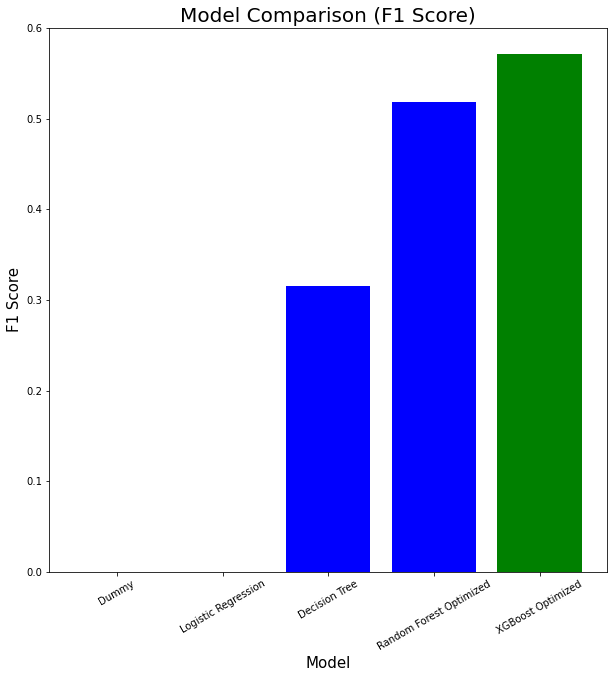

In [65]:
# plot the f1 scores of various models against one another
fig, ax = plt.subplots(figsize=(10,10))

ax.bar(model_results.keys(), model_results.values(), color=['blue', 'blue', 'blue', 'blue', 'green']);
ax.set_title('Model Comparison (F1 Score)', fontsize=20);
ax.set_ylabel('F1 Score', fontsize=15);
ax.set_xlabel('Model', fontsize=15);
ax.set_xticklabels(model_results.keys(), rotation = 30);

plt.savefig('./images/modelcomparison.png', dpi=400, facecolor='white')

In [70]:
initial = 15000
ind = []
sp = []
mymodel = []

In [71]:
for i in range(11):
    indpower = 1.019
    sppower = 1.056
    mypower = 1.1212
    ind.append(indpower**i * initial)
    sp.append(sppower**i * initial)
    mymodel.append(mypower**i * initial)

In [72]:
ind

[15000.0,
 15284.999999999998,
 15575.414999999997,
 15871.347884999994,
 16172.903494814995,
 16480.188661216474,
 16793.312245779587,
 17112.3851784494,
 17437.520496839938,
 17768.833386279894,
 18106.44122061921]

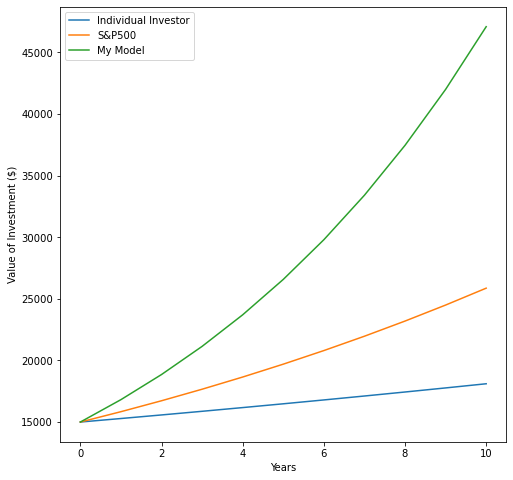

In [74]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(ind, label='Individual Investor');
ax.plot(sp, label='S&P500');
ax.plot(mymodel, label='My Model');
ax.set_xlabel('Years');
ax.set_ylabel('Value of Investment ($)');
ax.legend();

plt.savefig('./images/10yrinvest.png', dpi=400, facecolor='white')

## Conclusion

In conclusion, this model does relatively well at helping investors select which companies to buy. Given that from 1999-2018 the average investor had a 1.9% CAGR, my model on unseen data created a portfolio that returned 12% CAGR.

## Next Steps

With more time and resources, here are a few next steps that we would like to pursue for this project:
- Ingest more data: this initial model was built on data from 2009-2012, but there is public market data dating back over 100 years. The first step I will take in improving this model is to intake and clean all available historical data on publicly traded companies. 
- Further tune model: with more time, I could run more grid searches with more hyper parameters included. Some of these grid searches could take multiple days, so I would need significantly more time to optimize the final model.